In [2]:
from numpy.linalg import norm
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.datasets import load_svmlight_file
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.validation import check_is_fitted, check_array, check_X_y, check_random_state
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ParameterGrid,GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import get_data_home
from LMNN import LargeMarginNearestNeighbor
from LMNN_SS import SemiSupervisedLargeMarginNearestNeighbor

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

from collections import Counter
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from pylmnn import lmnn

import pandas as pd
import cv2
import os
import time
import csv

In [6]:
###Benchmark Grid Search Hyperparameters K, omega1,2, 3 #############
lmnn_itr_list=[2,5,10,30, 50,75,100]
ssc_itr_list=[2, 5, 10, 30, 50,75,100]

lmnn_param_grid = {'max_iter': lmnn_itr_list}
ssc_param_grid = {'max_iter': ssc_itr_list}

In [5]:
def cross_validate_test(clf, X, y, cv=5):
    print ("###### Cross Validate Data Shape: ", X.shape)
    skf = StratifiedKFold(n_splits=cv) 
    scores_list=[]
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        scores_list.append(clf.score(X_test,y_test))
    print ("##### Average Performance: ", np.mean(scores_list))
    return scores_list

### Test 1 : Find the Best max_itr for USPS (Labeled: 200, Unlabeled: 4000, Test: 2000)
***
*  **LMNN **

In [132]:
def get_USPS_training_data():
    data = load_svmlight_file('ml_data/usps/usps')
    return data[0], data[1]

def get_USPS_testing_data():
    data = load_svmlight_file('ml_data/usps/usps.t')
    return data[0], data[1]

X_train, y_train = get_USPS_training_data()
X_test, y_test = get_USPS_testing_data()

X_train=np.asarray(X_train.todense())
y_train=np.asarray(y_train)

X_test=np.asarray(X_test.todense())
y_test=np.asarray(y_test)

X_all=np.concatenate((X_train, X_test), axis=0)
y_all=np.concatenate((y_train, y_test), axis=0)
my_model = PCA(n_components=0.95, svd_solver='full')
X_all=my_model.fit_transform(X_all)


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=2000, stratify=y_all, random_state=42)
X_train_labelled, X_train_rest, y_train_labelled, y_train_rest = train_test_split(X_train, y_train, train_size=200, stratify=y_train, random_state=42)

u_X_train_labelled, u_X_train_rest, u_y_train_labelled, u_y_train_rest = train_test_split(X_train, y_train, train_size=200,shuffle=False)


X_train_rest, X_train_unlabelled, y_train_rest, y_train_unlabelled = train_test_split(X_train_rest, y_train_rest, test_size=4000, stratify=y_train_rest, random_state=42)

In [87]:
##### LMNN TUNNING USPS ########  (Long execution!!)
lmnnclf = GridSearchCV(LargeMarginNearestNeighbor(), lmnn_param_grid, cv=10, n_jobs=20, verbose=3)
lmnnclf.fit(X_train_labelled, y_train_labelled)

print("LMNN Best parameters set found on development set:")
print()
print(lmnnclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = lmnnclf.cv_results_['mean_test_score']
stds = lmnnclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lmnnclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, lmnnclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 

[CV] max_iter=100 ....................................................
[CV] ................ max_iter=75, score=0.695652173913, total= 2.9min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=30, score=0.772727272727, total= 6.0min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=75, score=0.928571428571, total= 2.8min
[CV] ................ max_iter=50, score=0.928571428571, total= 5.7min
[CV] ............... max_iter=100, score=0.826086956522, total= 3.2min
[CV] ............... max_iter=100, score=0.695652173913, total= 2.9min
[CV] ................ max_iter=75, score=0.826086956522, total= 3.8min


[Parallel(n_jobs=20)]: Done  55 out of  70 | elapsed:  7.1min remaining:  1.9min


[CV] ................ max_iter=75, score=0.888888888889, total= 3.8min
[CV] ........................... max_iter=50, score=0.8, total= 7.0min
[CV] ............... max_iter=100, score=0.826086956522, total= 3.4min
[CV] ................ max_iter=75, score=0.826086956522, total= 5.1min
[CV] .......................... max_iter=100, score=0.7, total= 2.6min
[CV] ................ max_iter=75, score=0.928571428571, total= 4.7min
[CV] ............... max_iter=100, score=0.928571428571, total= 2.2min
[CV] ................ max_iter=50, score=0.772727272727, total= 8.1min
[CV] ............... max_iter=100, score=0.888888888889, total= 2.8min
[CV] ............... max_iter=100, score=0.826086956522, total= 4.6min
[CV] ........................... max_iter=75, score=0.8, total= 5.9min
[CV] ............... max_iter=100, score=0.928571428571, total= 3.7min
[CV] ................ max_iter=75, score=0.772727272727, total= 6.8min
[CV] .......................... max_iter=100, score=0.8, total= 4.3min
[CV] .

[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed: 10.4min finished


LMNN Best parameters set found on development set:
()
{'max_iter': 30}
()
Grid scores on development set:
()
0.805 (+/-0.135) for {'max_iter': 2}
0.795 (+/-0.168) for {'max_iter': 5}
0.805 (+/-0.162) for {'max_iter': 10}
0.810 (+/-0.148) for {'max_iter': 30}
0.810 (+/-0.148) for {'max_iter': 50}
0.810 (+/-0.148) for {'max_iter': 75}
0.810 (+/-0.148) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

        1.0       0.88      0.96      0.92       334
        2.0       0.94      0.99      0.97       273
        3.0       0.80      0.77      0.78       200
        4.0       0.79      0.88      0.83       177
        5.0       0.85      0.79      0.82       183
        6.0       0.88      0.69      0.77       154
        7.0       0.91      0.89      0.90       180
        8.0       0.90      0.92      0.91       170
     

*  **SSC **

In [88]:
##### SSC LMNN TUNNING USPS ######## (Long execution!!)
sscclf = GridSearchCV(SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled), ssc_param_grid, cv=10, n_jobs=20, verbose=3)
sscclf.fit(X_train_labelled, y_train_labelled)

print("SSC Best parameters set found on development set:")
print()
print(sscclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = sscclf.cv_results_['mean_test_score']
stds = sscclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, sscclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, sscclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 

[CV] max_iter=100 ....................................................
[CV] ................ max_iter=75, score=0.869565217391, total= 3.9min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=75, score=0.826086956522, total= 5.4min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=75, score=0.782608695652, total= 4.9min
[CV] ........................... max_iter=75, score=0.8, total= 4.5min
[CV] ............... max_iter=100, score=0.869565217391, total= 3.3min
[CV] ............... max_iter=100, score=0.826086956522, total= 4.3min
[CV] ................ max_iter=50, score=0.857142857143, total= 9.4min


[Parallel(n_jobs=20)]: Done  55 out of  70 | elapsed: 10.5min remaining:  2.9min


[CV] ................ max_iter=75, score=0.944444444444, total= 5.2min
[CV] ............... max_iter=100, score=0.782608695652, total= 4.4min
[CV] ............... max_iter=100, score=0.826086956522, total= 5.2min
[CV] .......................... max_iter=100, score=0.8, total= 3.8min
[CV] .......................... max_iter=75, score=0.75, total= 6.6min
[CV] ............... max_iter=100, score=0.944444444444, total= 4.4min
[CV] ................ max_iter=75, score=0.857142857143, total= 7.2min
[CV] ......................... max_iter=100, score=0.75, total= 5.1min
[CV] ................ max_iter=50, score=0.928571428571, total=12.3min
[CV] ................ max_iter=50, score=0.772727272727, total=13.1min
[CV] ............... max_iter=100, score=0.857142857143, total= 6.2min
[CV] ................ max_iter=75, score=0.928571428571, total= 9.5min
[CV] ................ max_iter=75, score=0.772727272727, total=10.6min
[CV] ............... max_iter=100, score=0.928571428571, total= 7.1min
[CV] .

[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed: 16.4min finished


SSC Best parameters set found on development set:
()
{'max_iter': 10}
()
Grid scores on development set:
()
0.790 (+/-0.189) for {'max_iter': 2}
0.805 (+/-0.162) for {'max_iter': 5}
0.835 (+/-0.099) for {'max_iter': 10}
0.830 (+/-0.117) for {'max_iter': 30}
0.830 (+/-0.117) for {'max_iter': 50}
0.830 (+/-0.117) for {'max_iter': 75}
0.830 (+/-0.117) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

        1.0       0.91      0.96      0.93       334
        2.0       0.94      0.99      0.96       273
        3.0       0.82      0.81      0.82       200
        4.0       0.71      0.88      0.79       177
        5.0       0.80      0.76      0.78       183
        6.0       0.86      0.64      0.73       154
        7.0       0.90      0.89      0.90       180
        8.0       0.92      0.89      0.90       170
      

* **Compare with KNN**

In [137]:
print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4

print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled, y_train_labelled)
u_neigh = KNeighborsClassifier(n_neighbors=k)
u_neigh.fit(u_X_train_labelled, u_y_train_labelled)
print("USPS KNN : ",  neigh.score(X_test, y_test), " Unbalanced KNN: ", u_neigh.score(X_test, y_test))

lmnn = LargeMarginNearestNeighbor(max_iter=30)
lmnn.fit(X_train_labelled, y_train_labelled)
u_lmnn = LargeMarginNearestNeighbor(max_iter=30)
u_lmnn.fit(u_X_train_labelled, u_y_train_labelled)
o_lmnn = LargeMarginNearestNeighbor(max_iter=400)
o_lmnn.fit(X_train_labelled, y_train_labelled)
print("USPS LMNN : ", lmnn.score(X_test, y_test), " Unbalanced LMNN: ", u_lmnn.score(X_test, y_test), " Ovefitted LMNN: ", o_lmnn.score(X_test, y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=10)
ssc.fit(X_train_labelled, y_train_labelled)
u_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=10)
u_ssc.fit(u_X_train_labelled, u_y_train_labelled)
o_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=400)
o_ssc.fit(X_train_labelled, y_train_labelled)
print("USPS SSC : ", ssc.score(X_test, y_test), "Unbalanced SSC: ", u_ssc.score(X_test, y_test), " Ovefitted LMNN: ", o_ssc.score(X_test, y_test))

('######## Performance Test:  Labelled = ', (200, 33), '  ###  Unlabelled = ', (4000, 33), '###########')
('########  K = ', 4, ' ###########')
('USPS KNN : ', 0.852, ' Unbalanced KNN: ', 0.857)
('USPS LMNN : ', 0.871, ' Unbalanced LMNN: ', 0.854, ' Ovefitted LMNN: ', 0.871)
('USPS SSC : ', 0.8775, 'Unbalanced SSC: ', 0.873, ' Ovefitted LMNN: ', 0.8875)


***
### Test 2 : Find the Best max_itr for MNIST (Labeled: 200, Unlabeled: 4000, Test: 2000)
***
*  **LMNN **

In [76]:
mnist = fetch_mldata('MNIST original', data_home='ml_data/mnist')  #Download MMNIST
X_all, y_all = mnist.data, mnist.target
my_model = PCA(n_components=0.95, svd_solver='full')
X_all=my_model.fit_transform(X_all)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=2000, stratify=y_all, random_state=42)
X_train_labelled, X_train_rest, y_train_labelled, y_train_rest = train_test_split(X_train, y_train, train_size=200, stratify=y_train, random_state=42)

u_X_train_labelled, u_X_train_rest, u_y_train_labelled, u_y_train_rest = train_test_split(X_train, y_train, train_size=200,shuffle=False)

X_train_rest, X_train_unlabelled, y_train_rest, y_train_unlabelled = train_test_split(X_train_rest, y_train_rest, test_size=4000, stratify=y_train_rest, random_state=42)

In [50]:
##### LMNN TUNNING MNIST ########  (Long execution!!)
lmnnclf = GridSearchCV(LargeMarginNearestNeighbor(), lmnn_param_grid, cv=10, n_jobs=20, verbose=3)
lmnnclf.fit(X_train_labelled, y_train_labelled)

print("LMNN Best parameters set found on development set:")
print()
print(lmnnclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = lmnnclf.cv_results_['mean_test_score']
stds = lmnnclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lmnnclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, lmnnclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 

[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.294117647059, total= 1.8min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.368421052632, total= 1.9min
[CV] max_iter=100 ....................................................
[CV] .......................... max_iter=75, score=0.35, total= 2.6min
[CV] ........................... max_iter=75, score=0.3, total= 2.5min
[CV] .......................... max_iter=75, score=0.05, total= 2.6min
[CV] .......................... max_iter=75, score=0.35, total= 2.6min
[CV] ................ max_iter=75, score=0.380952380952, total= 2.8min
[CV] .......................... max_iter=75, score=0.35, total= 2.6min


[Parallel(n_jobs=20)]: Done  55 out of  70 | elapsed:  4.2min remaining:  1.2min


[CV] ................ max_iter=75, score=0.315789473684, total= 2.6min
[CV] ................ max_iter=75, score=0.409090909091, total= 3.0min
[CV] ................ max_iter=75, score=0.235294117647, total= 2.8min
[CV] ................ max_iter=75, score=0.285714285714, total= 3.2min
[CV] ............... max_iter=100, score=0.333333333333, total= 2.9min
[CV] .......................... max_iter=100, score=0.3, total= 2.7min
[CV] .......................... max_iter=100, score=0.4, total= 2.8min
[CV] .............. max_iter=100, score=0.0588235294118, total= 2.8min
[CV] ......................... max_iter=100, score=0.25, total= 2.9min
[CV] ............... max_iter=100, score=0.368421052632, total= 2.8min
[CV] .......................... max_iter=100, score=0.1, total= 3.0min
[CV] ............... max_iter=100, score=0.363636363636, total= 3.2min
[CV] .......................... max_iter=100, score=0.2, total= 3.1min
[CV] ............... max_iter=100, score=0.285714285714, total= 4.6min


[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed:  7.1min finished


LMNN Best parameters set found on development set:
()
{'max_iter': 2}
()
Grid scores on development set:
()
0.765 (+/-0.173) for {'max_iter': 2}
0.750 (+/-0.138) for {'max_iter': 5}
0.650 (+/-0.171) for {'max_iter': 10}
0.410 (+/-0.201) for {'max_iter': 30}
0.330 (+/-0.242) for {'max_iter': 50}
0.305 (+/-0.194) for {'max_iter': 75}
0.270 (+/-0.213) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

        0.0       0.79      0.96      0.87       197
        1.0       0.83      0.92      0.87       225
        2.0       0.81      0.74      0.78       200
        3.0       0.79      0.74      0.76       204
        4.0       0.86      0.67      0.76       195
        5.0       0.79      0.68      0.73       180
        6.0       0.84      0.91      0.88       197
        7.0       0.83      0.80      0.81       208
      

In [41]:
##### SSC LMNN TUNNING MNIST ######## (Long execution!!)
sscclf = GridSearchCV(SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled), ssc_param_grid, cv=10, n_jobs=20, verbose=3)
sscclf.fit(X_train_labelled, y_train_labelled)

print("SSC Best parameters set found on development set:")
print()
print(sscclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = sscclf.cv_results_['mean_test_score']
stds = sscclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, sscclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, sscclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 

[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.842105263158, total= 2.6min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.705882352941, total= 3.5min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=75, score=0.761904761905, total= 4.3min
[CV] ........................... max_iter=75, score=0.7, total= 4.8min
[CV] .......................... max_iter=75, score=0.75, total= 4.7min
[CV] ................ max_iter=75, score=0.772727272727, total= 5.5min
[CV] ........................... max_iter=75, score=0.6, total= 5.5min


[Parallel(n_jobs=20)]: Done  55 out of  70 | elapsed:  7.3min remaining:  2.0min


[CV] ................ max_iter=75, score=0.789473684211, total= 5.4min
[CV] ........................... max_iter=75, score=0.7, total= 5.6min
[CV] ................ max_iter=75, score=0.764705882353, total= 5.5min
[CV] ........................... max_iter=75, score=0.7, total= 6.0min
[CV] ................ max_iter=75, score=0.809523809524, total= 6.2min
[CV] ............... max_iter=100, score=0.809523809524, total= 7.6min
[CV] ............... max_iter=100, score=0.772727272727, total= 8.3min
[CV] .......................... max_iter=100, score=0.7, total= 8.4min
[CV] ......................... max_iter=100, score=0.75, total= 8.3min
[CV] ......................... max_iter=100, score=0.65, total= 9.2min
[CV] .......................... max_iter=100, score=0.7, total= 9.3min
[CV] .......................... max_iter=100, score=0.7, total= 9.8min
[CV] ............... max_iter=100, score=0.809523809524, total=10.0min
[CV] ............... max_iter=100, score=0.789473684211, total=10.3min
[CV] .

[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed: 14.1min finished


SSC Best parameters set found on development set:
()
{'max_iter': 2}
()
Grid scores on development set:
()
0.780 (+/-0.133) for {'max_iter': 2}
0.745 (+/-0.183) for {'max_iter': 5}
0.700 (+/-0.118) for {'max_iter': 10}
0.685 (+/-0.173) for {'max_iter': 30}
0.680 (+/-0.144) for {'max_iter': 50}
0.735 (+/-0.116) for {'max_iter': 75}
0.750 (+/-0.112) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

        0.0       0.81      0.95      0.87       197
        1.0       0.79      0.93      0.86       225
        2.0       0.77      0.78      0.78       200
        3.0       0.78      0.66      0.72       204
        4.0       0.72      0.72      0.72       195
        5.0       0.82      0.69      0.75       180
        6.0       0.87      0.88      0.87       197
        7.0       0.83      0.80      0.82       208
       

In [77]:
print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4

print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled, y_train_labelled)
u_neigh = KNeighborsClassifier(n_neighbors=k)
u_neigh.fit(u_X_train_labelled, u_y_train_labelled)
print("MNIST KNN : ",  neigh.score(X_test, y_test), " Unbalanced KNN: ", u_neigh.score(X_test, y_test))

lmnn = LargeMarginNearestNeighbor(max_iter=2)
lmnn.fit(X_train_labelled, y_train_labelled)
u_lmnn = LargeMarginNearestNeighbor(max_iter=2)
u_lmnn.fit(u_X_train_labelled, u_y_train_labelled)
o_lmnn = LargeMarginNearestNeighbor(max_iter=100)
o_lmnn.fit(X_train_labelled, y_train_labelled)
print("MNIST LMNN : ", lmnn.score(X_test, y_test), " Unbalanced LMNN: ", u_lmnn.score(X_test, y_test), " Ovefitted LMNN: ", o_lmnn.score(X_test, y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=5)
ssc.fit(X_train_labelled, y_train_labelled)
u_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=5)
u_ssc.fit(u_X_train_labelled, u_y_train_labelled)
o_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=100)
o_ssc.fit(X_train_labelled, y_train_labelled)
print("MNIST SSC : ", ssc.score(X_test, y_test), "Unbalanced SSC: ", u_ssc.score(X_test, y_test), " Ovefitted LMNN: ", o_ssc.score(X_test, y_test))


('######## Performance Test:  Labelled = ', (200, 154), '  ###  Unlabelled = ', (4000, 154), '###########')
('########  K = ', 4, ' ###########')
('MNIST KNN : ', 0.7535, ' Unbalanced KNN: ', 0.789)
('MNIST LMNN : ', 0.7825, ' Unbalanced LMNN: ', 0.7965, ' Ovefitted LMNN: ', 0.306)
('MNIST SSC : ', 0.772, 'Unbalanced SSC: ', 0.78, ' Ovefitted LMNN: ', 0.657)


***
### Test 3 : Find the Best max_itr for EMNIST (Labeled: 200, Unlabeled: 4000, Test: 2000) https://www.kaggle.com/crawford/emnist
***
*  **LMNN **

In [74]:
df = pd.read_csv('ml_data/emnist/emnist-balanced-train.csv')
df=df[df['45'].isin(['0','1','2','3','4','5','6','7','8','9'])]
y_all =df['45'].as_matrix()
X_all=df.drop(['45'], axis=1).as_matrix()
my_model = PCA(n_components=0.95, svd_solver='full')
X_all=my_model.fit_transform(X_all)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=2000, stratify=y_all, random_state=42)
X_train_labelled, X_train_rest, y_train_labelled, y_train_rest = train_test_split(X_train, y_train, train_size=200, stratify=y_train, random_state=42)


u_X_train_labelled, u_X_train_rest, u_y_train_labelled, u_y_train_rest = train_test_split(X_train, y_train, train_size=200,shuffle=False)

X_train_rest, X_train_unlabelled, y_train_rest, y_train_unlabelled = train_test_split(X_train_rest, y_train_rest, test_size=4000, stratify=y_train_rest, random_state=42)

In [53]:
##### LMNN TUNNING EMNIST ########  (Long execution!!)
lmnnclf = GridSearchCV(LargeMarginNearestNeighbor(), lmnn_param_grid, cv=10, n_jobs=20, verbose=3)
lmnnclf.fit(X_train_labelled, y_train_labelled)

print("LMNN Best parameters set found on development set:")
print()
print(lmnnclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = lmnnclf.cv_results_['mean_test_score']
stds = lmnnclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lmnnclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, lmnnclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 

[CV] max_iter=100 ....................................................
[CV] ........................... max_iter=50, score=0.5, total= 2.2min
[CV] max_iter=100 ....................................................
[CV] .......................... max_iter=75, score=0.45, total= 2.4min
[CV] max_iter=100 ....................................................
[CV] ........................... max_iter=75, score=0.4, total= 2.4min
[CV] ........................... max_iter=50, score=0.6, total= 3.2min
[CV] .......................... max_iter=75, score=0.65, total= 2.6min
[CV] ........................... max_iter=75, score=0.2, total= 2.6min
[CV] .......................... max_iter=75, score=0.45, total= 2.6min


[Parallel(n_jobs=20)]: Done  55 out of  70 | elapsed:  3.8min remaining:  1.0min


[CV] .......................... max_iter=75, score=0.55, total= 3.2min
[CV] ........................... max_iter=75, score=0.5, total= 3.6min
[CV] ......................... max_iter=100, score=0.35, total= 2.6min
[CV] .......................... max_iter=100, score=0.4, total= 3.0min
[CV] .......................... max_iter=100, score=0.5, total= 3.6min
[CV] .......................... max_iter=100, score=0.3, total= 3.3min
[CV] ........................... max_iter=75, score=0.4, total= 4.6min
[CV] .......................... max_iter=100, score=0.6, total= 4.0min
[CV] .......................... max_iter=100, score=0.5, total= 4.2min
[CV] .......................... max_iter=100, score=0.4, total= 3.3min
[CV] .......................... max_iter=75, score=0.45, total= 6.1min
[CV] ......................... max_iter=100, score=0.55, total= 5.3min
[CV] ......................... max_iter=100, score=0.45, total= 5.5min
[CV] ........................... max_iter=75, score=0.6, total= 7.0min
[CV] .

[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed:  8.3min finished


LMNN Best parameters set found on development set:
()
{'max_iter': 2}
()
Grid scores on development set:
()
0.795 (+/-0.192) for {'max_iter': 2}
0.735 (+/-0.245) for {'max_iter': 5}
0.630 (+/-0.201) for {'max_iter': 10}
0.470 (+/-0.237) for {'max_iter': 30}
0.425 (+/-0.262) for {'max_iter': 50}
0.465 (+/-0.237) for {'max_iter': 75}
0.465 (+/-0.195) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

          0       0.83      0.91      0.87       200
          1       0.63      0.97      0.76       200
          2       0.89      0.70      0.79       200
          3       0.90      0.68      0.77       200
          4       0.80      0.87      0.83       200
          5       0.86      0.79      0.82       200
          6       0.92      0.90      0.91       200
          7       0.76      0.90      0.82       200
      

*  **SSC **

In [172]:
##### SSC LMNN TUNNING EMNIST ######## (Long execution!!)
sscclf = GridSearchCV(SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled), ssc_param_grid, cv=5, n_jobs=20, verbose=3)
sscclf.fit(X_train_labelled, y_train_labelled)

print("SSC Best parameters set found on development set:")
print()
print(sscclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = sscclf.cv_results_['mean_test_score']
stds = sscclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, sscclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, sscclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=10 .....................................................
[CV] max_iter=10 .....................................................
[CV] max_iter=10 .....................................................
[CV] max_iter=10 

[Parallel(n_jobs=20)]: Done   8 out of  35 | elapsed:   23.4s remaining:  1.3min


[CV] .......................... max_iter=5, score=0.825, total=  23.6s
[CV] max_iter=75 .....................................................
[CV] ............................ max_iter=5, score=0.8, total=  27.6s
[CV] max_iter=75 .....................................................
[CV] ........................... max_iter=10, score=0.7, total=  33.8s
[CV] max_iter=100 ....................................................
[CV] .......................... max_iter=10, score=0.65, total=  37.9s
[CV] max_iter=100 ....................................................
[CV] ......................... max_iter=10, score=0.575, total=  39.0s
[CV] max_iter=100 ....................................................
[CV] ......................... max_iter=10, score=0.725, total=  40.8s
[CV] max_iter=100 ....................................................
[CV] ......................... max_iter=10, score=0.725, total=  41.7s
[CV] max_iter=100 ....................................................
[CV] .

[Parallel(n_jobs=20)]: Done  20 out of  35 | elapsed:  1.7min remaining:  1.3min


[CV] ......................... max_iter=50, score=0.675, total= 2.4min
[CV] ........................... max_iter=50, score=0.6, total= 2.5min
[CV] .......................... max_iter=50, score=0.65, total= 2.5min
[CV] ........................... max_iter=50, score=0.7, total= 2.5min
[CV] .......................... max_iter=50, score=0.65, total= 2.7min
[CV] ......................... max_iter=75, score=0.675, total= 3.2min
[CV] ........................... max_iter=75, score=0.7, total= 3.2min
[CV] .......................... max_iter=75, score=0.65, total= 3.2min
[CV] ......................... max_iter=75, score=0.575, total= 3.3min
[CV] ........................... max_iter=75, score=0.6, total= 3.4min
[CV] ......................... max_iter=100, score=0.65, total= 4.3min
[CV] ......................... max_iter=100, score=0.55, total= 4.6min


[Parallel(n_jobs=20)]: Done  32 out of  35 | elapsed:  5.3min remaining:   29.8s


[CV] ......................... max_iter=100, score=0.75, total= 5.6min
[CV] ......................... max_iter=100, score=0.65, total= 6.0min
[CV] ........................ max_iter=100, score=0.675, total= 6.1min


[Parallel(n_jobs=20)]: Done  35 out of  35 | elapsed:  6.7min finished


SSC Best parameters set found on development set:
()
{'max_iter': 2}
()
Grid scores on development set:
()
0.755 (+/-0.037) for {'max_iter': 2}
0.740 (+/-0.163) for {'max_iter': 5}
0.675 (+/-0.114) for {'max_iter': 10}
0.655 (+/-0.066) for {'max_iter': 30}
0.655 (+/-0.066) for {'max_iter': 50}
0.640 (+/-0.093) for {'max_iter': 75}
0.655 (+/-0.128) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

          0       0.82      0.89      0.85       200
          1       0.70      0.98      0.81       200
          2       0.80      0.68      0.73       200
          3       0.82      0.81      0.82       200
          4       0.74      0.83      0.78       200
          5       0.87      0.74      0.80       200
          6       0.90      0.88      0.89       200
          7       0.70      0.85      0.77       200
       

In [75]:
print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4

print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled, y_train_labelled)
u_neigh = KNeighborsClassifier(n_neighbors=k)
u_neigh.fit(u_X_train_labelled, u_y_train_labelled)
print("EMNIST KNN : ",  neigh.score(X_test, y_test), " Unbalanced KNN: ", u_neigh.score(X_test, y_test))

lmnn = LargeMarginNearestNeighbor(max_iter=2)
lmnn.fit(X_train_labelled, y_train_labelled)
u_lmnn = LargeMarginNearestNeighbor(max_iter=2)
u_lmnn.fit(u_X_train_labelled, u_y_train_labelled)
o_lmnn = LargeMarginNearestNeighbor(max_iter=100)
o_lmnn.fit(X_train_labelled, y_train_labelled)
print("EMNIST LMNN : ", lmnn.score(X_test, y_test), " Unbalanced LMNN: ", u_lmnn.score(X_test, y_test), " Ovefitted LMNN: ", o_lmnn.score(X_test, y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=5)
ssc.fit(X_train_labelled, y_train_labelled)
u_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=5)
u_ssc.fit(u_X_train_labelled, u_y_train_labelled)
o_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=100)
o_ssc.fit(X_train_labelled, y_train_labelled)
print("EMNIST SSC : ", ssc.score(X_test, y_test), "Unbalanced SSC: ", u_ssc.score(X_test, y_test), " Ovefitted LMNN: ", o_ssc.score(X_test, y_test))


('######## Performance Test:  Labelled = ', (200, 98), '  ###  Unlabelled = ', (4000, 98), '###########')
('########  K = ', 4, ' ###########')
('EMNIST KNN : ', 0.755, ' Unbalanced KNN: ', 0.733)
('EMNIST LMNN : ', 0.8035, ' Unbalanced LMNN: ', 0.782, ' Ovefitted LMNN: ', 0.704)
('EMNIST SSC : ', 0.805, 'Unbalanced SSC: ', 0.7255, ' Ovefitted LMNN: ', 0.7795)


***
### Test 4 : Find the Best max_itr for Devanagari Character Set (Labeled: 200, Unlabeled: 4000, Test: 2000) https://www.kaggle.com/rishianand/devanagari-character-set
***
*  **LMNN **

In [124]:
#X = np.loadtxt('ml_data/Devanagari/Devanagari.csv',delimiter=',')
df = pd.read_csv('ml_data/Devanagari/Devanagari.csv')
df = df[df['character'].isin(['character_01_ka','character_02_kha','character_03_ga','character_04_gha','character_05_kna', 'character_06_cha',
       'character_07_chha', 'character_08_ja', 'character_09_jha'])]
y_all=np.array(df['character'].tolist())
df.drop('character', axis=1, inplace=True)
X_all = df.astype(np.uint8).as_matrix()

my_model = PCA(n_components=0.95, svd_solver='full')
X_all=my_model.fit_transform(X_all)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=2000, stratify=y_all, random_state=42)
X_train_labelled, X_train_rest, y_train_labelled, y_train_rest = train_test_split(X_train, y_train, train_size=200, stratify=y_train, random_state=42)
u_X_train_labelled, u_X_train_rest, u_y_train_labelled, u_y_train_rest = train_test_split(X_train, y_train, train_size=200,shuffle=False)

X_train_rest, X_train_unlabelled, y_train_rest, y_train_unlabelled = train_test_split(X_train_rest, y_train_rest, test_size=4000, stratify=y_train_rest, random_state=42)

In [87]:
##### LMNN TUNNING DC ########  (Long execution!!)
lmnnclf = GridSearchCV(LargeMarginNearestNeighbor(), lmnn_param_grid, cv=10, n_jobs=20, verbose=3)
lmnnclf.fit(X_train_labelled, y_train_labelled)

print("LMNN Best parameters set found on development set:")
print()
print(lmnnclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = lmnnclf.cv_results_['mean_test_score']
stds = lmnnclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lmnnclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, lmnnclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 

[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.166666666667, total= 2.8min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.222222222222, total= 2.8min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=75, score=0.407407407407, total= 2.7min
[CV] ................ max_iter=75, score=0.333333333333, total= 2.7min
[CV] ........................... max_iter=75, score=0.1, total= 3.6min
[CV] ................ max_iter=75, score=0.166666666667, total= 3.6min
[CV] ................ max_iter=75, score=0.166666666667, total= 3.6min


[Parallel(n_jobs=20)]: Done  55 out of  70 | elapsed:  5.8min remaining:  1.6min


[CV] ................ max_iter=75, score=0.277777777778, total= 3.5min
[CV] ................ max_iter=75, score=0.111111111111, total= 3.8min
[CV] ................ max_iter=75, score=0.222222222222, total= 3.7min
[CV] ................ max_iter=100, score=0.37037037037, total= 3.3min
[CV] ................ max_iter=75, score=0.166666666667, total= 3.6min
[CV] ................ max_iter=75, score=0.166666666667, total= 3.6min
[CV] ............... max_iter=100, score=0.259259259259, total= 3.6min
[CV] .......................... max_iter=100, score=0.2, total= 3.6min
[CV] ............... max_iter=100, score=0.222222222222, total= 3.5min
[CV] ............... max_iter=100, score=0.222222222222, total= 3.4min
[CV] ............... max_iter=100, score=0.222222222222, total= 3.5min
[CV] ............... max_iter=100, score=0.222222222222, total= 3.5min
[CV] ............... max_iter=100, score=0.166666666667, total= 3.4min
[CV] ............... max_iter=100, score=0.111111111111, total= 3.5min
[CV] .

[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed:  7.5min finished


LMNN Best parameters set found on development set:
()
{'max_iter': 2}
()
Grid scores on development set:
()
0.730 (+/-0.225) for {'max_iter': 2}
0.690 (+/-0.263) for {'max_iter': 5}
0.535 (+/-0.219) for {'max_iter': 10}
0.330 (+/-0.144) for {'max_iter': 30}
0.260 (+/-0.166) for {'max_iter': 50}
0.225 (+/-0.203) for {'max_iter': 75}
0.225 (+/-0.139) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
                   precision    recall  f1-score   support

  character_01_ka       0.81      0.85      0.83       222
 character_02_kha       0.74      0.65      0.70       222
  character_03_ga       0.71      0.87      0.79       222
 character_04_gha       0.60      0.69      0.64       223
 character_05_kna       0.70      0.63      0.66       222
 character_06_cha       0.76      0.86      0.81       222
character_07_chha       0.68      0.58      0.63       223
  character

*  **SSC **

In [292]:
##### SSC LMNN TUNNING EMNIST ######## (Long execution!!)
sscclf = GridSearchCV(SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled), ssc_param_grid, cv=10, n_jobs=20, verbose=3)
sscclf.fit(X_train_labelled, y_train_labelled)

print("SSC Best parameters set found on development set:")
print()
print(sscclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = sscclf.cv_results_['mean_test_score']
stds = sscclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, sscclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, sscclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=2 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 ......................................................
[CV] max_iter=5 

[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.277777777778, total=15.9min
[CV] max_iter=100 ....................................................
[CV] ........................... max_iter=50, score=0.5, total=17.6min
[CV] max_iter=100 ....................................................
[CV] ................ max_iter=50, score=0.592592592593, total=18.7min
[CV] ........................... max_iter=50, score=0.5, total=19.6min
[CV] ........................... max_iter=75, score=0.5, total=16.9min
[CV] ........................... max_iter=50, score=0.5, total=22.4min
[CV] ............... max_iter=100, score=0.777777777778, total=11.1min


[Parallel(n_jobs=20)]: Done  55 out of  70 | elapsed: 25.0min remaining:  6.8min


[CV] ................ max_iter=75, score=0.277777777778, total=13.7min
[CV] ........................... max_iter=75, score=0.5, total=19.7min
[CV] ........................... max_iter=75, score=0.4, total=20.5min
[CV] ............... max_iter=100, score=0.666666666667, total= 7.6min
[CV] ............... max_iter=100, score=0.555555555556, total= 8.7min
[CV] ................ max_iter=75, score=0.518518518519, total=23.9min
[CV] ............... max_iter=100, score=0.277777777778, total= 9.4min
[CV] .......................... max_iter=100, score=0.5, total=12.0min
[CV] .......................... max_iter=100, score=0.5, total=14.2min
[CV] ................ max_iter=75, score=0.592592592593, total=25.5min
[CV] ........................... max_iter=75, score=0.5, total=23.5min
[CV] ................ max_iter=100, score=0.62962962963, total=19.1min
[CV] ......................... max_iter=100, score=0.45, total=18.8min
[CV] ............... max_iter=100, score=0.592592592593, total=20.3min
[CV] .

[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed: 32.7min finished


SSC Best parameters set found on development set:
()
{'max_iter': 5}
()
Grid scores on development set:
()
0.700 (+/-0.252) for {'max_iter': 2}
0.740 (+/-0.209) for {'max_iter': 5}
0.710 (+/-0.241) for {'max_iter': 10}
0.560 (+/-0.286) for {'max_iter': 30}
0.540 (+/-0.252) for {'max_iter': 50}
0.530 (+/-0.249) for {'max_iter': 75}
0.550 (+/-0.248) for {'max_iter': 100}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
                   precision    recall  f1-score   support

  character_01_ka       0.86      0.85      0.85       222
 character_02_kha       0.74      0.65      0.70       222
  character_03_ga       0.63      0.86      0.73       222
 character_04_gha       0.56      0.58      0.57       223
 character_05_kna       0.74      0.64      0.68       222
 character_06_cha       0.64      0.77      0.70       222
character_07_chha       0.73      0.55      0.63       223
  character_

In [90]:
print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4

print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled, y_train_labelled)
u_neigh = KNeighborsClassifier(n_neighbors=k)
u_neigh.fit(u_X_train_labelled, u_y_train_labelled)
print("DC KNN : ",  neigh.score(X_test, y_test), " Unbalanced KNN: ", u_neigh.score(X_test, y_test))

lmnn = LargeMarginNearestNeighbor(max_iter=2)
lmnn.fit(X_train_labelled, y_train_labelled)
u_lmnn = LargeMarginNearestNeighbor(max_iter=2)
u_lmnn.fit(u_X_train_labelled, u_y_train_labelled)
o_lmnn = LargeMarginNearestNeighbor(max_iter=100)
o_lmnn.fit(X_train_labelled, y_train_labelled)
print("DC LMNN : ", lmnn.score(X_test, y_test), " Unbalanced LMNN: ", u_lmnn.score(X_test, y_test), " Ovefitted LMNN: ", o_lmnn.score(X_test, y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=5)
ssc.fit(X_train_labelled, y_train_labelled)
u_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=5)
u_ssc.fit(u_X_train_labelled, u_y_train_labelled)
o_ssc = SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled,max_iter=100)
o_ssc.fit(X_train_labelled, y_train_labelled)
print("DC SSC : ", ssc.score(X_test, y_test), "Unbalanced SSC: ", u_ssc.score(X_test, y_test), " Ovefitted SSC: ", o_ssc.score(X_test, y_test))


('######## Performance Test:  Labelled = ', (200, 177), '  ###  Unlabelled = ', (4000, 177), '###########')
('########  K = ', 4, ' ###########')
('DC KNN : ', 0.715, ' Unbalanced KNN: ', 0.6595)
('DC LMNN : ', 0.752, ' Unbalanced LMNN: ', 0.7365, ' Ovefitted LMNN: ', 0.1865)
('DC SSC : ', 0.723, 'Unbalanced SSC: ', 0.732, ' Ovefitted SSC: ', 0.585)


***
### Performance Test Plot (Labeled: 200, Unlabeled: 4000, Test: 2000) 
***

In [135]:
raw_data = {'Dataset': ['USPS', 'MNIST', 'EMNIST', 'DC'],
        'KNN': [0.852, 0.7535,  0.755, 0.715],
        'LMNN': [0.871,  0.7825, 0.8035,0.752],
        'SS-LMNN': [0.8775, 0.7875, 0.807, 0.723],
        'Unbalanced KNN': [0.857,  0.789, 0.733,0.6595],
        'Unbalanced LMNN': [ 0.854,  0.7965, 0.782, 0.732],
        'Unbalanced SS-LMNN': [ 0.873, 0.78,  0.7255, 0.723],
        'Overfitted LMNN': [0.871,  0.306, 0.704,0.1865],
        'Overfitted SS-LMNN': [0.8875,  0.657,  0.7795, 0.585]}
df = pd.DataFrame(raw_data, columns = ['Dataset', 'KNN', 'LMNN', 'SS-LMNN', 'Unbalanced KNN', 'Unbalanced LMNN', 'Unbalanced SS-LMNN', 'Overfitted LMNN',  'Overfitted SS-LMNN'])
df['KNN']=df['KNN']*100
df['LMNN']=df['LMNN']*100
df['SS-LMNN']=df['SS-LMNN']*100
df['Unbalanced KNN']=df['Unbalanced KNN']*100
df['Unbalanced LMNN']=df['Unbalanced LMNN']*100
df['Unbalanced SS-LMNN']=df['Unbalanced SS-LMNN']*100
df['Overfitted LMNN']=df['Overfitted LMNN']*100
df['Overfitted SS-LMNN']=df['Overfitted SS-LMNN']*100

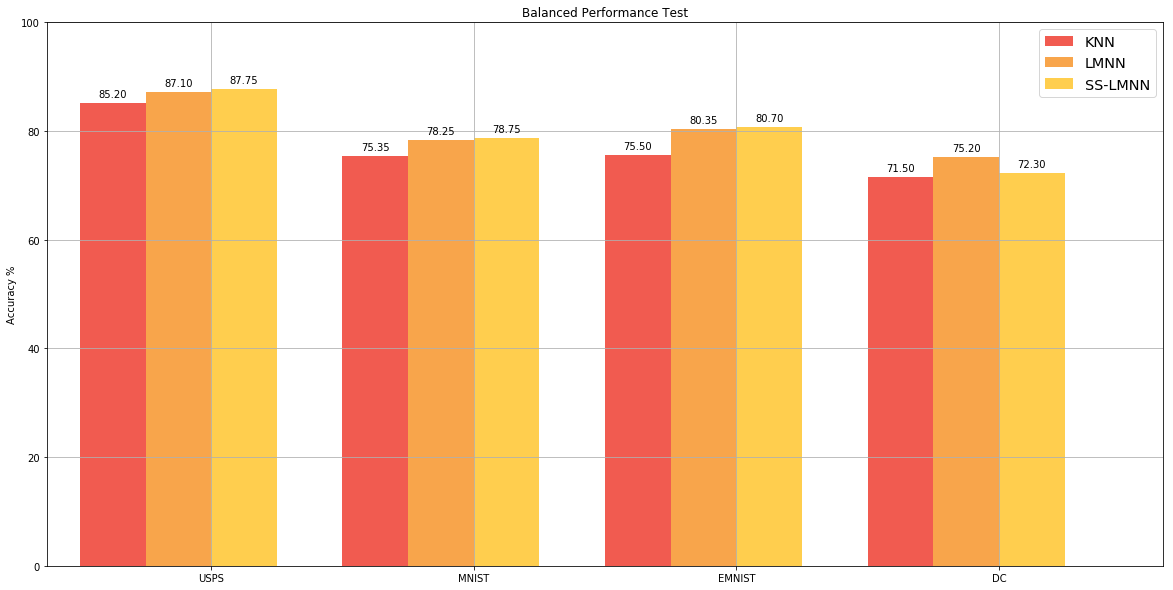

In [155]:
# Setting the positions and width for the bars
pos = list(range(len(df['KNN']))) 
width = 0.25
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['KNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=df['Dataset'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['LMNN'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label=df['Dataset'][0]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df['SS-LMNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label=df['Dataset'][0]) 


for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.2f" % p.get_height(), xy=(x,h), xytext=(0,4), 
                   textcoords="offset points", ha="center", va="bottom")

# Set the y axis label
ax.set_ylabel('Accuracy %')

# Set the chart's title
ax.set_title('Balanced Performance Test')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['Dataset'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 100] )

# Adding the legend and showing the plot
plt.legend(['KNN', 'LMNN', 'SS-LMNN'], loc='upper right', fontsize = 'x-large')
plt.grid()
plt.savefig('balanced_performance.pdf',bbox_inches='tight', dpi=200)
plt.show()

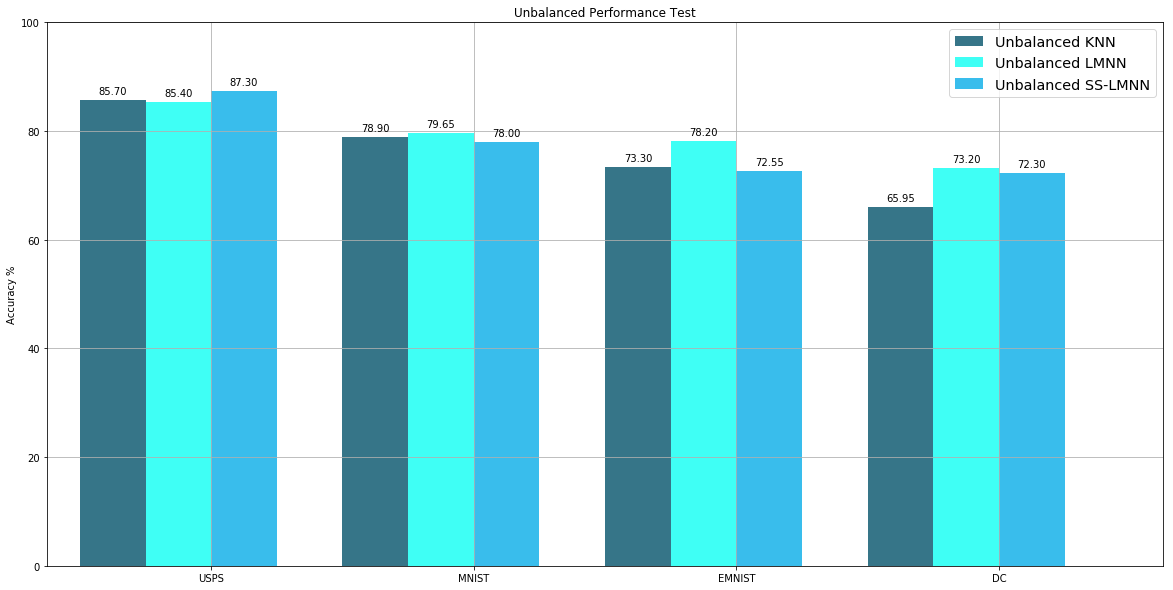

In [154]:
# Setting the positions and width for the bars
pos = list(range(len(df['KNN']))) 
width = 0.25
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['Unbalanced KNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#03536B', 
        # with label the first value in first_name
        label=df['Dataset'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['Unbalanced LMNN'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#0FFFF3', 
        # with label the second value in first_name
        label=df['Dataset'][0]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df['Unbalanced SS-LMNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#07ADE8',
        # with label the third value in first_name
        label=df['Dataset'][0]) 


for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.2f" % p.get_height(), xy=(x,h), xytext=(0,4), 
                   textcoords="offset points", ha="center", va="bottom")

# Set the y axis label
ax.set_ylabel('Accuracy %')

# Set the chart's title
ax.set_title('Unbalanced Performance Test')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['Dataset'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 100] )

# Adding the legend and showing the plot
plt.legend(['Unbalanced KNN', 'Unbalanced LMNN', 'Unbalanced SS-LMNN'], loc='upper right', fontsize = 'x-large')
plt.grid()
plt.savefig('unbalanced_performance.pdf',bbox_inches='tight', dpi=200)
plt.show()

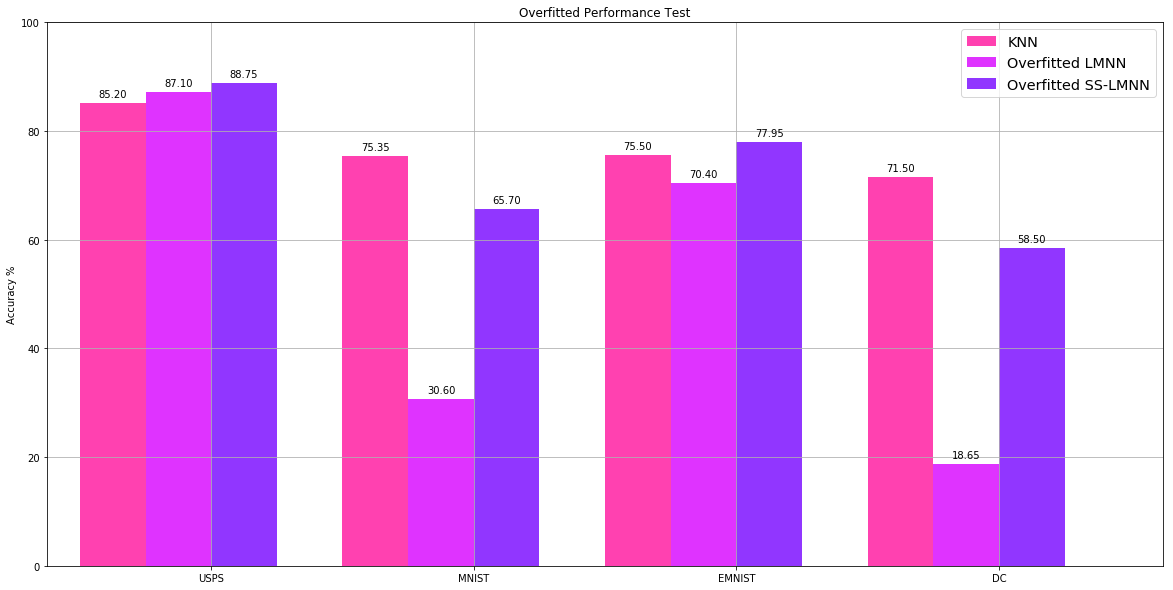

In [153]:
# Setting the positions and width for the bars
pos = list(range(len(df['KNN']))) 
width = 0.25
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['KNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#FF119C', 
        # with label the first value in first_name
        label=df['Dataset'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['Overfitted LMNN'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#D700FF', 
        # with label the second value in first_name
        label=df['Dataset'][0]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df['Overfitted SS-LMNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.8, 
        # with color
        color='#7603FF', 
        # with label the third value in first_name
        label=df['Dataset'][0]) 


for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%.2f" % p.get_height(), xy=(x,h), xytext=(0,4), 
                   textcoords="offset points", ha="center", va="bottom")

# Set the y axis label
ax.set_ylabel('Accuracy %')

# Set the chart's title
ax.set_title('Overfitted Performance Test')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['Dataset'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 100] )

# Adding the legend and showing the plot
plt.legend(['KNN', 'Overfitted LMNN', 'Overfitted SS-LMNN'], loc='upper right', fontsize = 'x-large')
plt.grid()
plt.savefig('overfitted_performance.pdf',bbox_inches='tight', dpi=200)
plt.show()